# Thrift Hunter Machine Learning Model

## Download and prepare the dataset

In [1]:
# Permission to download the dataset
! chmod 600 kaggle.json

In [2]:
!KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d dqmonn/zalando-store-crawl

 99% 2.22G/2.24G [00:12<00:00, 221MB/s]
100% 2.24G/2.24G [00:12<00:00, 197MB/s]


In [3]:
# Extract the dataset
import zipfile

zip_file = zipfile.ZipFile('/content/zalando-store-crawl.zip')
zip_file.extractall('/content/')

In [4]:
# Check one of the images inside the dataset
import cv2

img = cv2.imread("/content/zalando/longsleeve/1VJ22O059-Q11@7.jpg")

img.shape

(875, 606, 3)

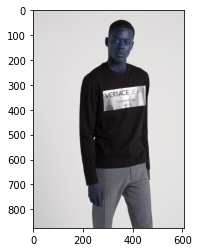

In [5]:
import matplotlib.pyplot as plt

plt.imshow(img)

In [6]:
!rm -rf /content/zalando/zalando

In [7]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
# Split folders
import splitfolders
from sklearn.model_selection import train_test_split

input_folder = '/content/zalando'

# train, val
splitfolders.ratio(input_folder, output="/content/zalando2", 
                   seed=42, ratio=(.8, .2), 
                   group_prefix=None) # default values

Copying files: 16186 files [00:04, 3682.42 files/s]


## Prepare the ImageDataGenerator

In [9]:
# Initialize ImageDataGenerator for training and testing
from keras_preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale= 1./255,                                                                                                                   
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range = 0.2, 
                               horizontal_flip=True,
                               fill_mode = 'nearest')

val_datagen = ImageDataGenerator(rescale= 1./255)

In [10]:
# Take image data from directory and resize it
TRAINING_DIR = '/content/zalando2/train'
VALIDATION_DIR = '/content/zalando2/val'

train_data = train_datagen.flow_from_directory(TRAINING_DIR,
                                           target_size = (224,224),
                                           class_mode = 'categorical',
                                           batch_size = 126)

val_data = val_datagen.flow_from_directory(VALIDATION_DIR,
                                         target_size = (224,224),
                                         class_mode = 'categorical',
                                         batch_size = 126)

Found 12943 images belonging to 6 classes.
Found 3237 images belonging to 6 classes.


In [11]:
labels = list(train_data.class_indices.keys())

labels

['hoodies',
 'hoodies-female',
 'longsleeve',
 'shirt',
 'sweatshirt',
 'sweatshirt-female']

## Build the model

In [16]:
# Build ResNet model
from tensorflow.keras import Input, Model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

base_model = ResNet50V2(weights='imagenet',
                        input_shape=(224,224,3),
                        include_top=False)

input = Input(shape=(224,224,3))

x = base_model(input, training=False)
x = GlobalAveragePooling2D()(x)

output = Dense(6, activation='softmax')(x)

model = Model(input, output)

In [17]:
# Model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 23,577,094
Trainable params: 23,531,654
Non-trainable params: 45,440
_________________________________________________________________


In [18]:
# Compile the model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

# Set the training parameters
model.compile(
    loss = categorical_crossentropy,
    optimizer = Adam(),
    metrics = ['accuracy'])

## Train the model and evaluate the results

In [19]:
# Fit the data to the model
history = model.fit(
    train_data,
    epochs=5,
    steps_per_epoch=102,
    validation_data=val_data,
    verbose=1,
    validation_steps=25)

Epoch 1/5
102/102 [==============================] - 343s 3s/step - loss: 0.9365 - accuracy: 0.5981 - val_loss: 4.0564 - val_accuracy: 0.2730
Epoch 2/5
102/102 [==============================] - 329s 3s/step - loss: 0.7027 - accuracy: 0.6651 - val_loss: 1.0152 - val_accuracy: 0.6098
Epoch 3/5
102/102 [==============================] - 331s 3s/step - loss: 0.6362 - accuracy: 0.6917 - val_loss: 0.8465 - val_accuracy: 0.6149
Epoch 4/5
102/102 [==============================] - 337s 3s/step - loss: 0.6136 - accuracy: 0.6945 - val_loss: 1.0969 - val_accuracy: 0.5648
Epoch 5/5
102/102 [==============================] - 327s 3s/step - loss: 0.5817 - accuracy: 0.7126 - val_loss: 0.8300 - val_accuracy: 0.6397


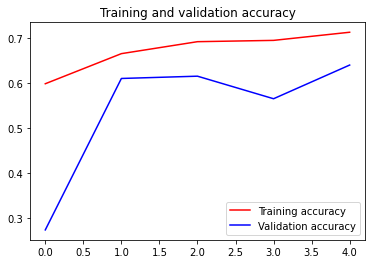

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

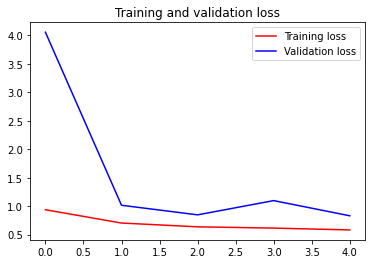

<Figure size 432x288 with 0 Axes>

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

## Save Model

In [1]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [43]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model('model') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [25]:
# !unzip model.zip

In [2]:
from tensorflow.keras.models import load_model

model = load_model('model')

In [3]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 23,577,094
Trainable params: 23,531,654
Non-trainable params: 45,440
_________________________________________________________________


In [4]:
model.save('model.h5')

## Test the Saved Model

In [5]:
# Test the saved model

test_model = load_model('model.h5')

In [6]:
test_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 23,577,094
Trainable params: 23,531,654
Non-trainable params: 45,440
_________________________________________________________________


In [9]:
import tensorflow as tf
import numpy as np

def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, [224,224])
    img = tf.cast(img, tf.float32)/255.0
    img = img[np.newaxis, :, :, :]
    return img

In [10]:
img = load_image('/content/BH921J00V-E11@10.jpg')

In [11]:
result = model.predict(img)

result

array([[2.4125210e-04, 4.6755612e-01, 4.7013322e-07, 1.4156808e-07,
        4.4515936e-04, 5.3175682e-01]], dtype=float32)

In [12]:
!tensorflowjs_converter --input_format=tf_saved_model model web_model

2022-06-10 21:07:02.612831: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Writing weight file web_model/model.json...


In [35]:
!zip -r zalando.zip "/content/zalando"

Streaming output truncated to the last 5000 lines.
  adding: content/zalando/sweatshirt/MI422S01P-M11@15.2.jpg (deflated 1%)
  adding: content/zalando/sweatshirt/JOG22S000-Q11@8.jpg (deflated 0%)
  adding: content/zalando/sweatshirt/JA222S0TS-Q11@10.jpg (deflated 0%)
  adding: content/zalando/sweatshirt/GRD22S006-M11@16.1.jpg (deflated 1%)
  adding: content/zalando/sweatshirt/PI922SA0W-B11@13.1.jpg (deflated 0%)
  adding: content/zalando/sweatshirt/THB22S00M-C11@7.jpg (deflated 0%)
  adding: content/zalando/sweatshirt/YT142G009-Q11@10.jpg (deflated 1%)
  adding: content/zalando/sweatshirt/BO122S02M-B11@7.jpg (deflated 1%)
  adding: content/zalando/sweatshirt/A0Q22S01B-C11@10.jpg (deflated 1%)
  adding: content/zalando/sweatshirt/LE422S013-C11@8.jpg (deflated 1%)
  adding: content/zalando/sweatshirt/M0M22S04P-Q11@7.1.jpg (deflated 1%)
  adding: content/zalando/sweatshirt/MI422S01J-E11@8.jpg (deflated 1%)
  adding: content/zalando/sweatshirt/M9122S05A-C11@12.jpg (deflated 1%)
  adding: c

In [13]:
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model